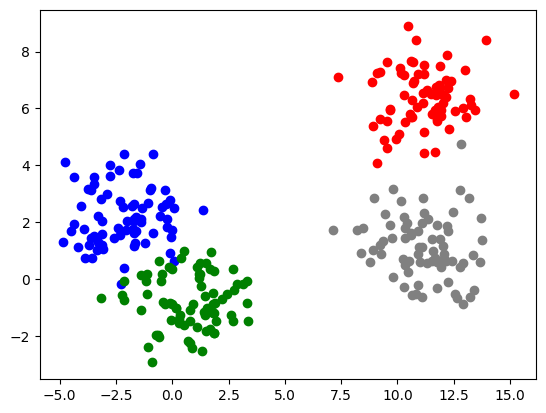

RuntimeError: Could not infer dtype of numpy.float32

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset
data = pd.read_csv('../data/data_3_2.csv').to_numpy()
x = data[:, :-1]  # Features (x1, x2)
y = data[:, -1]   # Labels (class 0, 1, 2, or 3)


# Plot the data for visualization
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], color='blue')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='red')
plt.scatter(x[y == 2][:, 0], x[y == 2][:, 1], color='green')
plt.scatter(x[y == 3][:, 0], x[y == 3][:, 1], color='grey')
plt.show()


# Feature scaling
def feature_scaling(x):
    mu = np.mean(x, axis=0)
    return (x - mu) / (np.max(x, axis=0) - np.min(x, axis=0))

x_scaled = feature_scaling(x)

# Convert data to tensors
tx = torch.tensor(x_scaled, dtype=torch.float32)

# Define a binary classification model
class BinaryModel(nn.Module):
    def __init__(self, num_input):
        super().__init__()
        self.linear1 = nn.Linear(num_input, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))  # Sigmoid for binary classification
        return x

    def train(self, x, y, num_iter=500, lr=0.1):
        opt = optim.SGD(self.parameters(), lr=lr)
        criterion = nn.BCELoss()
        for i in range(num_iter):
            z = self(x).flatten()
            loss = criterion(z, y)
            if i % 100 == 0:
                print(f'iter: {i}, loss: {loss.item()}')
            loss.backward()
            opt.step()
            opt.zero_grad()

    def evaluate(self, x, y):
        z = self(x).flatten()
        predictions = (z > 0.5).float()
        accuracy = (predictions == y).float().mean()
        return accuracy

# Function to convert target labels into binary labels for one-vs-rest classification
def prepare_binary_labels(class_to_isolate, y):
    return torch.tensor((y == class_to_isolate).astype(np.float32))

# One-vs-Rest Training and Evaluation
def train_one_vs_rest(class_idx, tx, ty, num_iter=1000, lr=0.1):
    binary_labels = prepare_binary_labels(class_idx, ty)
    model = BinaryModel(tx.shape[1])  # Binary model
    model.train(tx, binary_labels, num_iter=num_iter, lr=lr)
    accuracy = model.evaluate(tx, binary_labels)
    print(f'Class {class_idx} vs rest, Accuracy: {accuracy.item()}')
    return accuracy.item()

# Prepare the labels as integers (original multiclass labels)
ty = torch.tensor(y, dtype=torch.long)

# Run the one-vs-rest models for each class and compare results
accuracies = {}
for class_idx in range(4):
    accuracies[class_idx] = train_one_vs_rest(class_idx, tx, y, num_iter=1000, lr=0.1)

# Compare accuracies for each class
best_class = max(accuracies, key=accuracies.get)
print(f'The best performing class is Class {best_class} with an accuracy of {accuracies[best_class]}')